In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch

import pandas as pd
import numpy as np
import scanpy as sc
import os
import yaml
from pathlib import Path
from tqdm import tqdm


os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#os.environ['R_HOME'] = 'D:/software/R/R-4.3.2'
#os.environ['R_USER'] = 'D:/software/anaconda/anaconda3/envs/pt20cu118/Lib/site-packages/rpy2'
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.decomposition import PCA

import STG3Net as MODEL

def mapping2int(string_array):
    mapping = {}
    result = []
    for string in string_array:
        if string not in mapping:
            mapping[string] = len(mapping)
        result.append(mapping[string])
    return result, mapping

def get_data(proj_list, config):
    global graph_dict
    data_root = Path('../../data/DLPFC')
    result, mapping = mapping2int(proj_list)
    for proj_name in tqdm(proj_list):
        adata_tmp = sc.read_visium(data_root / proj_name, count_file=proj_name + "_filtered_feature_bc_matrix.h5")
        adata_tmp.var_names_make_unique()

        adata_tmp.obs['batch_name'] = proj_name
        adata_tmp.obs['slice_id'] = mapping[proj_name]

        ##### Load layer_guess label, if have
        truth_path = "../../data/DLPFC/" + proj_name + '/' + 'manual_annotations.txt'
        Ann_df = pd.read_csv(truth_path, sep='\t', header=None, index_col=0)
        Ann_df.columns = ['Ground Truth']
        adata_tmp.obs['layer_guess'] = Ann_df.loc[adata_tmp.obs_names, 'Ground Truth']
        adata_tmp = adata_tmp[~pd.isnull(adata_tmp.obs['layer_guess'])]

        graph_dict_tmp = MODEL.graph_construction(adata_tmp, config['k_cutoff'])
        if proj_name == proj_list[0]:
            adata = adata_tmp
            graph_dict = graph_dict_tmp
            name = proj_name
            adata.obs['proj_name'] = proj_name
        else:
            var_names = adata.var_names.intersection(adata_tmp.var_names)
            adata = adata[:, var_names]
            adata_tmp = adata_tmp[:, var_names]
            adata_tmp.obs['proj_name'] = proj_name

            adata = adata.concatenate(adata_tmp)
            graph_dict = MODEL.combine_graph_dict(graph_dict, graph_dict_tmp)
            name = name + '_' + proj_name

    adata.layers['count'] = adata.X.toarray()
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.filter_genes(adata, min_counts=10)
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=config['top_genes'])
    adata = adata[:, adata.var['highly_variable'] == True]
    sc.pp.scale(adata)

    adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
    adata.obsm['X_pca'] = adata_X
    return adata, graph_dict

In [2]:
with open('Config/Config_DLPFC.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

proj_list = ['151669', '151670', '151671', '151672']
num_cluster = 5

adata, graph_dict = get_data(proj_list, config['data'])

100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = MODEL.G3net(adata, graph_dict=graph_dict, device=device, config=config, num_cluster=num_cluster)

In [4]:
net.train(verbose=1)

Epoch 495 total loss=0.781 recon loss=0.923 tri loss=0.000 disc loss=1.346:  50%|█████     | 500/1000 [00:17<00:16, 30.46it/s]R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
Processing datasets 151669 have 48085 nodes or edges
Processing datasets 151670 have 48427 nodes or edges
Processing datasets 151671 have 71947 nodes or edges
Processing datasets 151672 have 58896 nodes or edges


Epoch 545 total loss=1.091 recon loss=0.990 tri loss=0.261 disc loss=1.378:  55%|█████▍    | 549/1000 [00:35<00:22, 19.70it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151669 have 76819 nodes or edges
Processing datasets 151670 have 71709 nodes or edges
Processing datasets 151671 have 87835 nodes or edges
Processing datasets 151672 have 82342 nodes or edges


Epoch 595 total loss=1.118 recon loss=1.060 tri loss=0.238 disc loss=1.379:  60%|█████▉    | 599/1000 [00:54<00:17, 22.95it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151669 have 82140 nodes or edges
Processing datasets 151670 have 78178 nodes or edges
Processing datasets 151671 have 92545 nodes or edges
Processing datasets 151672 have 87266 nodes or edges


Epoch 645 total loss=1.067 recon loss=0.981 tri loss=0.241 disc loss=1.396:  65%|██████▌   | 650/1000 [01:11<00:13, 25.08it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151669 have 75675 nodes or edges
Processing datasets 151670 have 73409 nodes or edges
Processing datasets 151671 have 85010 nodes or edges


Epoch 645 total loss=1.067 recon loss=0.981 tri loss=0.241 disc loss=1.396:  65%|██████▌   | 650/1000 [01:24<00:13, 25.08it/s]

Processing datasets 151672 have 84638 nodes or edges


Epoch 695 total loss=1.115 recon loss=1.017 tri loss=0.263 disc loss=1.402:  70%|██████▉   | 698/1000 [01:28<00:12, 24.33it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151669 have 81761 nodes or edges
Processing datasets 151670 have 78868 nodes or edges
Processing datasets 151671 have 94297 nodes or edges
Processing datasets 151672 have 87802 nodes or edges


Epoch 745 total loss=1.065 recon loss=0.998 tri loss=0.227 disc loss=1.391:  75%|███████▍  | 748/1000 [01:46<00:10, 24.49it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151669 have 81603 nodes or edges
Processing datasets 151670 have 77994 nodes or edges
Processing datasets 151671 have 90912 nodes or edges
Processing datasets 151672 have 85242 nodes or edges


Epoch 795 total loss=1.062 recon loss=0.984 tri loss=0.234 disc loss=1.393:  80%|████████  | 800/1000 [02:05<00:08, 24.72it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151669 have 81885 nodes or edges
Processing datasets 151670 have 78667 nodes or edges
Processing datasets 151671 have 91573 nodes or edges
Processing datasets 151672 have 85962 nodes or edges


Epoch 845 total loss=1.028 recon loss=0.977 tri loss=0.206 disc loss=1.385:  85%|████████▌ | 850/1000 [02:21<00:06, 24.17it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151669 have 79430 nodes or edges
Processing datasets 151670 have 75038 nodes or edges
Processing datasets 151671 have 87609 nodes or edges


Epoch 845 total loss=1.028 recon loss=0.977 tri loss=0.206 disc loss=1.385:  85%|████████▌ | 850/1000 [02:34<00:06, 24.17it/s]

Processing datasets 151672 have 83977 nodes or edges


Epoch 895 total loss=1.053 recon loss=0.966 tri loss=0.239 disc loss=1.374:  90%|████████▉ | 899/1000 [02:39<00:04, 22.97it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151669 have 81903 nodes or edges
Processing datasets 151670 have 77742 nodes or edges
Processing datasets 151671 have 93080 nodes or edges
Processing datasets 151672 have 85239 nodes or edges


Epoch 945 total loss=1.021 recon loss=0.958 tri loss=0.212 disc loss=1.383:  95%|█████████▌| 950/1000 [02:55<00:02, 24.49it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151669 have 79389 nodes or edges
Processing datasets 151670 have 74795 nodes or edges
Processing datasets 151671 have 88871 nodes or edges
Processing datasets 151672 have 85113 nodes or edges


Epoch 980 total loss=1.030 recon loss=0.958 tri loss=0.222 disc loss=1.373:  98%|█████████▊| 980/1000 [03:11<00:03,  5.11it/s]

Stop trainning because of loss convergence


In [5]:
enc_rep, recon = net.process()
enc_rep = enc_rep.data.cpu().numpy()
recon = recon.data.cpu().numpy()
adata.obsm['latent'] = enc_rep
adata.obsm['recon'] = recon
print(adata)

AnnData object with n_obs × n_vars = 15101 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'batch_name', 'slice_id', 'layer_guess', 'proj_name', 'batch', 'Tmp_domain'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg'
    obsm: 'spatial', 'X_pca', 'latent', 'recon'
    layers: 'count'


In [6]:
adata = net.clustering(adata, num_cluster=num_cluster, used_obsm='latent', key_added_pred='mclust', method='mclust', random_seed=666)

fitting ...
  |======================================================================| 100%


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_mutual_info_score as ami_score
from sklearn.metrics import homogeneity_score as hom_score
from sklearn.metrics import completeness_score as com_score

In [8]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
ARI = ari_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total ARI:{ARI}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    ARI = ari_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    print(f"{name} ARI:{ARI}")

total ARI:0.5192322070412961
151669 ARI:0.5200104869104707
151670 ARI:0.5208064340548287
151671 ARI:0.5600763512164568
151672 ARI:0.5611454640697736


In [9]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
NMI = nmi_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total NMI:{NMI}")
AMI = ami_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total AMI:{AMI}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    NMI = nmi_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    AMI = ami_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    ACC = 1/2 * (NMI + AMI)
    print(f"{name} ACC:{ACC}")

total NMI:0.6342469031712875
total AMI:0.6341114361573732
151669 ACC:0.637651528640454
151670 ACC:0.6067591369539649
151671 ACC:0.6852033555987103
151672 ACC:0.6769149136932067


In [10]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
HOM = hom_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total HOM:{HOM}")
COM = com_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total COM:{COM}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    HOM = hom_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    COM = com_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    V =  2 * ((HOM * COM) / (HOM + COM))
    print(f"{name} V:{V}")

total HOM:0.6813070322231335
total COM:0.593267926219983
151669 V:0.6379527915728981
151670 V:0.60711753692602
151671 V:0.6854118376488992
151672 V:0.6771357621006199


2.896905413103435
1.0097417851144797


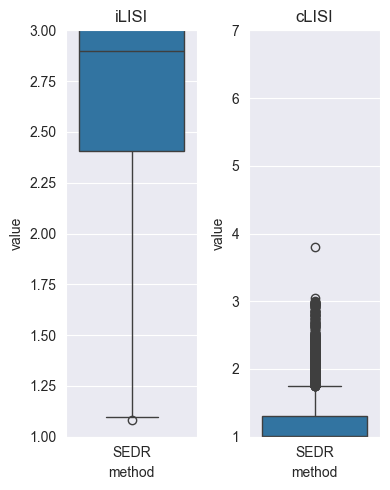

In [11]:
import harmonypy as hm

iLISI = hm.compute_lisi(adata.obsm['latent'], adata.obs[['batch_name']], label_colnames=['batch_name'])[:, 0]
cLISI = hm.compute_lisi(adata.obsm['latent'], adata.obs[['layer_guess']], label_colnames=['layer_guess'])[:, 0]

df_iLISI = pd.DataFrame({
    'method': 'SEDR',
    'value': iLISI,
    'type': ['ILISI'] * len(iLISI)
})

df_cLISI = pd.DataFrame({
    'method': 'SEDR',
    'value': cLISI,
    'type': ['CLISI'] * len(cLISI)
})

fig, axes = plt.subplots(1, 2, figsize=(4, 5))
sns.boxplot(data=df_iLISI, x='method', y='value', ax=axes[0])
sns.boxplot(data=df_cLISI, x='method', y='value', ax=axes[1])
axes[0].set_ylim(1, 3)
axes[1].set_ylim(1, 7)
axes[0].set_title('iLISI')
axes[1].set_title('cLISI')

plt.tight_layout()
print(np.median(iLISI))
print(np.median(cLISI))

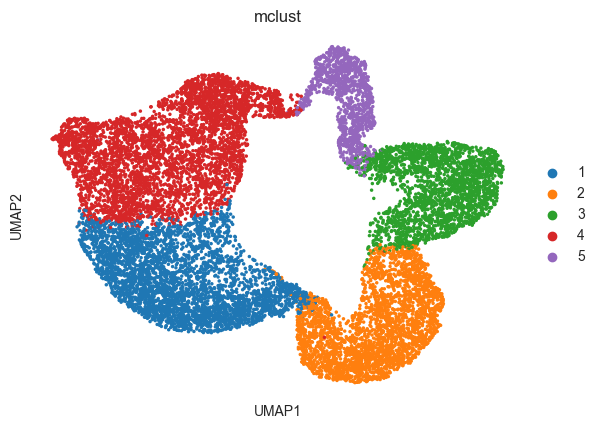

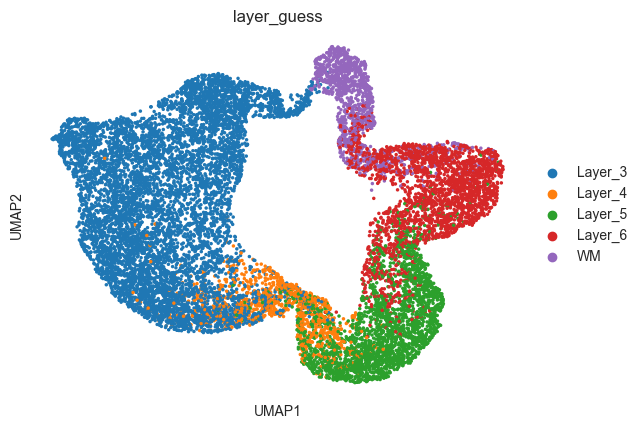

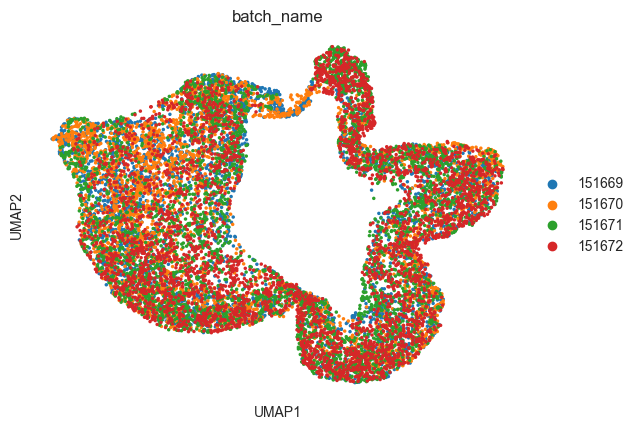

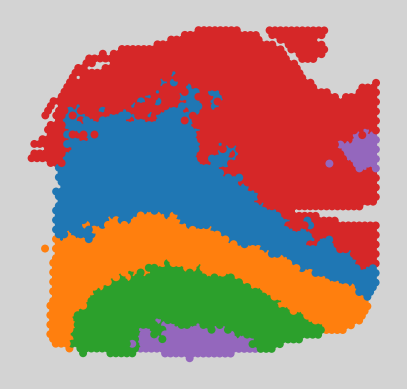

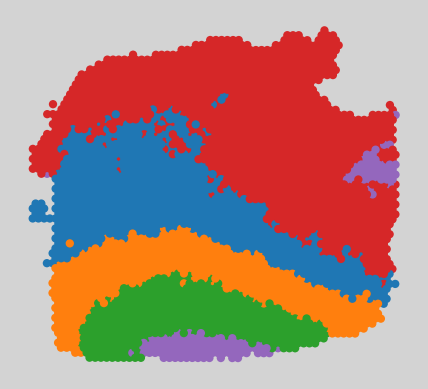

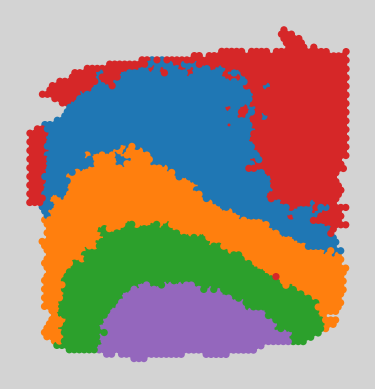

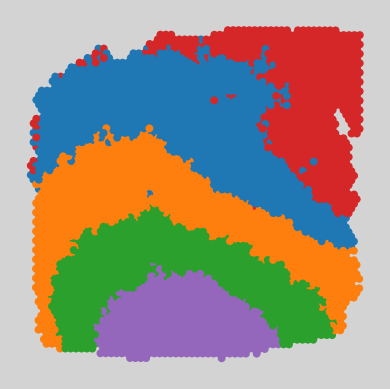

In [12]:
plt.rcParams['axes.facecolor'] = 'white'  # 设置子图的背景颜色
plt.rcParams['figure.facecolor'] = 'white'  # 设置整张图的背景颜色

sc.pp.neighbors(adata, use_rep='latent', random_state=666)
sc.tl.umap(adata, random_state=666)

sc.pl.umap(adata, color=['mclust'], show=True, size=25, save='STG3Net_M_Donor2.png')
sc.pl.umap(adata, color=['layer_guess'], show=True, size=25, save='STG3Net_G_Donor2.png')
sc.pl.umap(adata, color=['batch_name'], show=True, size=25, save='STG3Net_B_Donor2.png')

plt.rcParams['axes.facecolor'] = 'lightgray'  # 设置子图的背景颜色
plt.rcParams['figure.facecolor'] = 'lightgray'  # 设置整张图的背景颜色

for section_id in proj_list:
    adata_tmp = adata[adata.obs['batch_name'] == section_id]
    sc.pl.spatial(adata_tmp, img_key=None, color=['mclust'], title=[''],
                  legend_fontsize=12, show=False, frameon=False, legend_loc=None,
                  spot_size=200)

    plt.savefig('STG3Net_' + section_id + '.png', dpi=300, bbox_inches='tight')

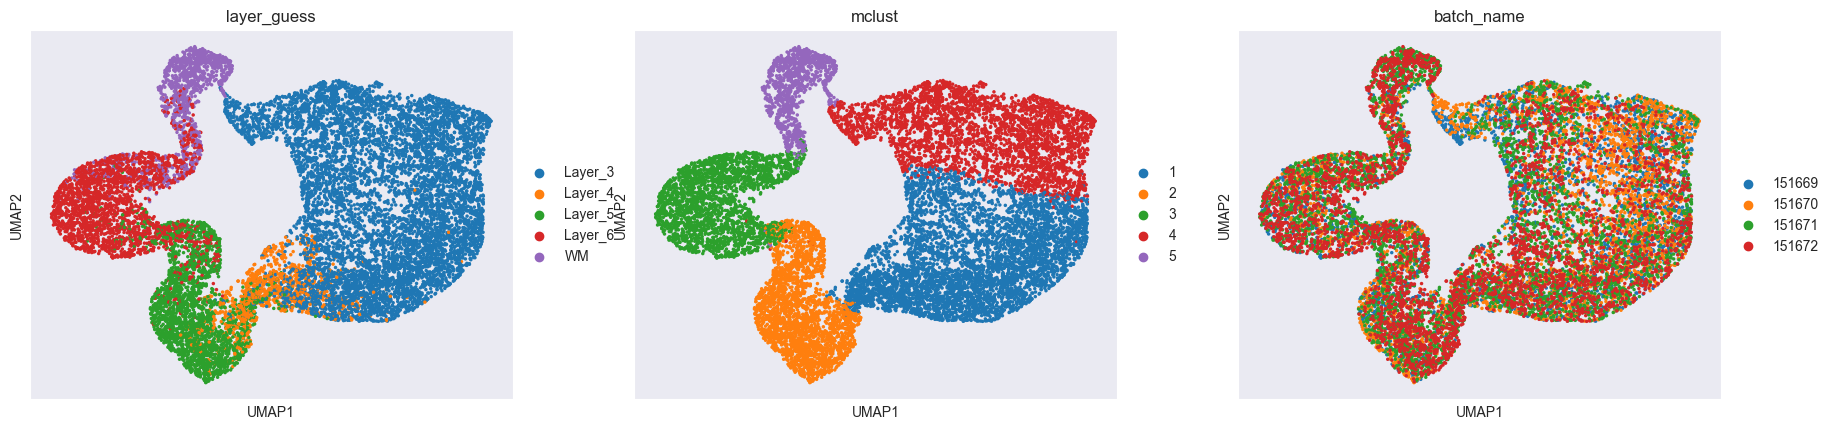

In [12]:
# %%
sc.pp.neighbors(adata, use_rep='latent', metric='cosine')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['layer_guess', 'mclust', 'batch_name'], show=True, size=25, save=False)

In [13]:
Batch_list = []
for section_id in proj_list:
    Batch_list.append(adata[adata.obs['batch_name'] == section_id])

spot_size = 200
title_size = 12
ARI_list = []
for bb in range(len(proj_list)):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['layer_guess'], Batch_list[bb].obs['mclust']), 3))


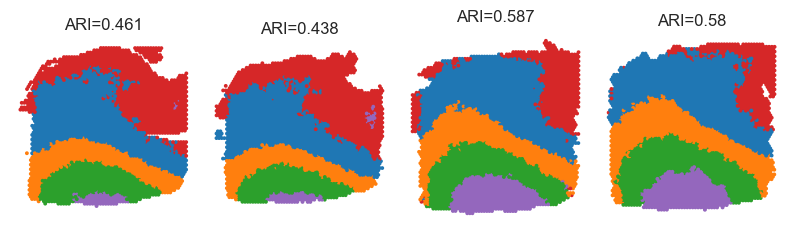

In [14]:

fig, ax = plt.subplots(1, 4, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for idx in range(len(proj_list)):
    _sc_ = sc.pl.spatial(Batch_list[idx], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[idx], frameon=False,
                      spot_size=spot_size)
    _sc_[0].set_title("ARI=" + str(ARI_list[idx]), size=title_size)
plt.show()